In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --quiet transformers==4.1.1
!pip install --quiet tokenizers==0.9.4 
!pip install --quiet sentencepiece==0.1.94
!pip install --quiet tqdm==4.56.0
!pip install --quiet pytorch-lightning==1.2.10

     |████████████████████████████████| 1.5 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 37.9 MB/s 
     |████████████████████████████████| 2.9 MB 38.3 MB/s 
     |████████████████████████████████| 1.1 MB 4.3 MB/s 
     |████████████████████████████████| 72 kB 788 kB/s 
     |████████████████████████████████| 841 kB 4.2 MB/s 
     |████████████████████████████████| 176 kB 50.3 MB/s 
     |████████████████████████████████| 132 kB 50.3 MB/s 
     |████████████████████████████████| 829 kB 41.6 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 1.1 MB 28.6 MB/s 
     |████████████████████████████████| 271 kB 47.3 MB/s 
     |████████████████████████████████| 160 kB 50.0 MB/s 
     |████████████████████████████████| 192 kB 47.9 MB/s 


In [ ]:
# restart your runtime or ctrl M

In [1]:
%cd /content/drive/My Drive/Text Mining TDDE16/

/content/drive/My Drive/Text Mining TDDE16


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import argparse


from transformers import (
    AdamW,
    get_linear_schedule_with_warmup,
    MT5ForConditionalGeneration, 
    T5Tokenizer
)

pl.seed_everything(42)

Global seed set to 42


42

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")
tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")

In [ ]:
from tqdm.notebook import tqdm
import copy

class QuestionGenerationDataset(Dataset):
    def __init__(self, tokenizer, filepath, max_len_inp=512, max_len_out=96):
        self.path = filepath

        self.passage_column = "context"
        self.answer = "answer"
        self.question = "question"

        # self.data = pd.read_csv(self.path)
        self.data = pd.read_csv(self.path,nrows=1000)

        self.max_len_input = max_len_inp
        self.max_len_output = max_len_out
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []

        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

        labels = copy.deepcopy(target_ids)
        labels [labels==0] = -100

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask,"labels":labels}

    def _build(self):
        for idx in tqdm(range(len(self.data))):
            passage,answer,target = self.data.loc[idx, self.passage_column],self.data.loc[idx, self.answer], self.data.loc[idx, self.question]

            input_ = "context: %s  answer: %s </s>" % (passage, answer)
            target = "question: %s </s>" % (str(target))

            # get encoding length of input. If it is greater than self.max_len skip it
            test_input_encoding = self.tokenizer.encode_plus(input_, truncation=False, return_tensors="pt")

            test_target_encoding = self.tokenizer.encode_plus(target, truncation=False, return_tensors="pt")
            
            length_of_input_encoding = len(test_input_encoding['input_ids'][0])

            length_of_target_encoding = len(test_target_encoding['input_ids'][0])


            if length_of_input_encoding > self.max_len_input or length_of_target_encoding > self.max_len_output:
              continue

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len_input, pad_to_max_length=True, return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len_output, pad_to_max_length=True,return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)


In [ ]:
train_file_path = 'dataset/squad_train.csv'
validation_file_path = 'dataset/squad_val.csv'

In [ ]:
train_dataset = QuestionGenerationDataset(tokenizer, train_file_path)


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padd

In [ ]:
validation_dataset = QuestionGenerationDataset(tokenizer, validation_file_path)


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
class mT5FineTuner(pl.LightningModule):
    def __init__(self,hparams, model, tokenizer):
        super(mT5FineTuner, self).__init__()
        self.hparams = hparams
        self.model = model
        self.tokenizer = tokenizer


    def forward( self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
         outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels
        )
         
         return outputs


    def training_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels']
        )

        loss = outputs[0]
        self.log('train_loss',loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels']
        )

        loss = outputs[0]
        self.log("val_loss",loss)
        return loss

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.hparams.batch_size,num_workers=4)

    def val_dataloader(self):
        return DataLoader(validation_dataset, batch_size=self.hparams.batch_size,num_workers=4)



    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=3e-4, eps=1e-8)
        return optimizer


In [ ]:
args_dict = dict(
    batch_size=4,
)

args = argparse.Namespace(**args_dict)


mT5model = mT5FineTuner(args, model, tokenizer)

trainer = pl.Trainer(max_epochs = 1, gpus=1, progress_bar_refresh_rate=30)

trainer.fit(mT5model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | MT5ForConditionalGeneration | 300 M 
------------------------------------------------------
300 M     Trainable params
0         Non-trainable params
300 M     Total params
1,200.707 Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [ ]:
print ("Saving model")
save_path_model = '/content/drive/My Drive/Text Mining TDDE16/mT5/model/'
save_path_tokenizer = '/content/drive/My Drive/Text Mining TDDE16/mT5/tokenizer/'

mT5model.model.save_pretrained(save_path_model)
tokenizer.save_pretrained(save_path_tokenizer)

Saving model


('/content/drive/My Drive/Text Mining TDDE16/mT5/tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/Text Mining TDDE16/mT5/tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/Text Mining TDDE16/mT5/tokenizer/spiece.model',
 '/content/drive/My Drive/Text Mining TDDE16/mT5/tokenizer/added_tokens.json')

In [3]:
trained_model_path = '/content/drive/My Drive/Text Mining TDDE16/mT5/model/'
trained_tokenizer = '/content/drive/My Drive/Text Mining TDDE16/mT5/tokenizer/'

In [4]:
model = MT5ForConditionalGeneration.from_pretrained(trained_model_path)
tokenizer = T5Tokenizer.from_pretrained(trained_tokenizer)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)

model = model.to(device)

device  cuda


In [ ]:
context = "Joe Biden Trump said and predicted that some states would reopen this month."
answer = "Joe Biden"
text = "context: "+context + " " + "answer: " + answer + " </s>"
print (text)

context: Joe Biden Trump said and predicted that some states would reopen this month. answer: Joe Biden </s>


In [7]:
train_df = pd.read_csv('dataset/squad_train.csv')

In [8]:
context = train_df.iloc[8]['context']
answer = train_df.iloc[8]['answer']
ques = train_df.iloc[8]['question']
text = "context: "+context + " " + "answer: " + answer + " </s>"
print (text)
print(ques)

context: The Mass of Paul VI was also in Latin but approval was given for the use of vernacular languages. There had been other instructions issued by the Pope in 1964, 1967, 1968, 1969 and 1970 which centered on the reform of all liturgies of the Roman Church. These major reforms were not welcomed by all and in all countries. The sudden apparent "outlawing" of the 400-year-old Mass, the last typical edition of which being promulgated only a few years earlier in 1962 by Paul's predecessor, Pope John XXIII, was not always explained well. Further experimentation with the new Mass by liturgists, such as the usage of pop/folk music (as opposed to the Gregorian Chant advocated by Pope Pius X), along with concurrent changes in the order of sanctuaries, was viewed by some as vandalism. In 2007, Pope Benedict XVI clarified that the 1962 Mass of John XXIII and the 1970 Mass of Paul VI are two forms of the same Roman Rite, the first, which had never been "juridically abrogated", now being an "ex

In [9]:
encoding = tokenizer.encode_plus(text, max_length =512, padding=True, return_tensors="pt")

input_ids, attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


In [12]:
model.eval()

beam_outputs = model.generate(
    input_ids=input_ids, 
    attention_mask=attention_mask,
    max_length=72,
    early_stopping=True,
    num_beams=5,
    num_return_sequences=3
)

for beam_output in beam_outputs:
    sent = tokenizer.decode(beam_output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print (sent)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1065: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


question: What was the Mass of Paul VI?
question: What was the Mass of Paul VI was the Mass of Paul VI?
question: What was the mass of Paul VI?


In [13]:
def generate_question(i):

  context = test_df.iloc[i]['context']
  answer = test_df.iloc[i]['answer']
  text = "context: "+ context + " " + "answer: " + answer + " </s>"

  encoding = tokenizer.encode_plus(text, max_length =512, padding=True, return_tensors="pt")

  input_ids, attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

  beam_outputs = model.generate(
      input_ids=input_ids, attention_mask=attention_mask,
      max_length=72,
      early_stopping=True,
      num_beams=5,
      num_return_sequences=3)

  sent = tokenizer.decode(beam_outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
  return sent

In [14]:
test_df = pd.read_csv('dataset/squad_test.csv', nrows=1000)
test_df.shape

(1000, 3)

In [15]:
test_pred = [generate_question(i) for i in range(len(test_df))]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1065: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [16]:
import re

In [17]:
test_pred_new = []
for t in test_pred:
  r = re.search('question:(.*)', t)
  test_pred_new.append(r.group(1).strip())

In [ ]:
acc = 0
for i in range(len(test_df)):
  if test_df.iloc[i]['question'].lower() == test_pred_new[i].lower():
    acc += 1

print('Exact Match:', acc/len(test_df))

Exact Match: 0.001


In [20]:
precision = []
recall = []
f1 = []

for i in range(len(test_df)):
  gold = set(test_df.iloc[i]['question'].lower().split())
  pred = set(test_pred_new[i].lower().split())

  if len(pred) == 0:
    continue

  p = len(gold & pred)/len(pred)
  precision.append(p)
  rc = len(gold & pred)/len(gold)
  recall.append(rc)

  if p + rc == 0:
    f1.append(0.0)
    continue
  f1.append(2 * (p * rc) / (p + rc))

print('Precision score: ', sum(precision)/len(test_df))
print('Recall score: ', sum(recall)/len(test_df))
print('F1 Score: ', sum(f1)/len(test_df))

Precision score:  0.25300241702741677
Recall score:  0.1337423990668106
F1 Score:  0.1689913376611098


In [ ]:
test_df.head()

,context,answer,question
0,Guinea-Bissau was once part of the kingdom of ...,political instability,Guinea-Bissau has a history of what since inde...
1,The quarter-wave elements imitate a series-res...,lossless,What could be the best possible output versus ...
2,New York City's commuter rail network is the l...,Manhattan,In what borough is Pennsylvania Station located?
3,"The end of a treaty, the eschatocol (or closin...",equally authentic,What is the nature of the different versions o...
4,The modern petroleum industry started in 1846 ...,Bóbrka,Where was the first Rock Oil mine built?


In [ ]:
from transformers import BertTokenizer, BertForQuestionAnswering

btokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bmodel = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
def answer_question(question, answer_text):

    input_ids = btokenizer.encode(question, answer_text)

    sep_index = input_ids.index(btokenizer.sep_token_id)

    num_seg_a = sep_index + 1

    num_seg_b = len(input_ids) - num_seg_a

    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    assert len(segment_ids) == len(input_ids)

    outputs = bmodel(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits
    
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    tokens = btokenizer.convert_ids_to_tokens(input_ids)

    answer = tokens[answer_start]

    for i in range(answer_start + 1, answer_end + 1):
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        else:
            answer += ' ' + tokens[i]

    return 'Answer: "' + answer + '"'

In [ ]:
question, text = test_df.iloc[8]['question'], test_df.iloc[8]['context']
print(answer_question(question, text))

question, text = test_pred_new[8], test_df.iloc[8]['context']
print(answer_question(question, text))

Answer: "packard"
Answer: "packard bell , and ast research struggled and eventually left the market or were bought out . dell surpassed compaq to become the largest pc"


In [ ]:
acc = []

for i in range(len(test_df)):
  q1, t = test_df.iloc[i]['question'], test_df.iloc[i]['context']
  q2 = test_pred_new[i]

  if len(t) > 2000:
    continue
  if answer_question(q1, t) == answer_question(q2, t):
    acc.append(1)
  else:
    acc.append(0)

print('SPS score: ', sum(acc) / len(acc))

SPS score:  0.4471299093655589


In [ ]:
!pip install --quiet sentence_transformers

     |████████████████████████████████| 78 kB 2.9 MB/s 
     |████████████████████████████████| 3.4 MB 23.2 MB/s 
     |████████████████████████████████| 6.8 MB 34.7 MB/s 
     |████████████████████████████████| 61 kB 488 kB/s 
     |████████████████████████████████| 3.3 MB 41.5 MB/s 


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
xsim = list(range(1, 1001))
sim = []
for i in range(1000):
  sen_embeddings = model.encode([test_df['question'][i], test_pred_new[i]])
  sim.append(cosine_similarity([sen_embeddings[0]], sen_embeddings[1:])[0][0])

print('SBERT similarity score: ', sum(sim)/len(sim))

SBERT similarity score:  0.4626916156280786


In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'SBERT Similarity')

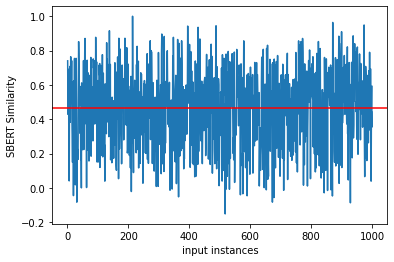

In [ ]:
plt.plot(xsim, sim)
plt.axhline(y=sum(sim)/len(sim), color='r', linestyle='-')
plt.xlabel("input instances")
plt.ylabel("SBERT Similarity")